## Heteroscedastic uncertainty

### Example of learning the aleatoric heteroscedastic uncertainty by learning a simple linear regression

In [2]:
!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

    100% |████████████████████████████████| 276kB 1.8MB/s eta 0:00:01


Using TensorFlow backend.


First we create some samples from 0 to 40 and add some noise in two batches, from 0 to 20 with std equals to 4, and from 20 to 40 with std 1. This is what we eant to predict as the uncertainty of the predictions based on the noise of the input data.

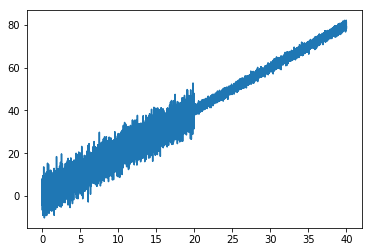

In [3]:
x = np.linspace(0, 20, 10000)#, dtype="int32")  # 100000 values between 0 and 100
delta = np.random.normal(0, 4, x.size)
y = 2*x + delta
x2 = np.linspace(20, 40, 10000)
delta2 = np.random.normal(0, 1, x2.size)
y2 = 2*x2 + delta2
x = np.append(x, x2)
y = np.append(y, y2)
plt.plot(x,y)
plt.show()

These are the function used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output.

In [4]:
def aleatoric_loss(y_true, y_pred):
    sigma = K.log(K.exp(y_pred[:, 1]) + 1)
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (K.square(sigma) + epsilon)) + K.log(K.square(sigma) + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    return K.mean(K.square(y_pred_prima - y_true[:, 0]), axis=-1)

def aleatoric_uncertainty(y_true, y_pred):
    sigma = y_pred[:, 1]
    return K.max(K.log(K.square(sigma)), axis=-1)

First we try a model without calculating the sigma and plot the results to see that the model is predicting the right values.

Epoch 1/40
20000/20000 [==============================] - 0s - loss: 66.1969 - mean_squared_error: 66.1969     
Epoch 2/40
20000/20000 [==============================] - 0s - loss: 28.7877 - mean_squared_error: 28.7877     
Epoch 3/40
20000/20000 [==============================] - 0s - loss: 15.2234 - mean_squared_error: 15.2234     
Epoch 4/40
20000/20000 [==============================] - 0s - loss: 10.1995 - mean_squared_error: 10.1995     
Epoch 5/40
20000/20000 [==============================] - 0s - loss: 8.6980 - mean_squared_error: 8.6980     
Epoch 6/40
20000/20000 [==============================] - 0s - loss: 8.3560 - mean_squared_error: 8.3560     
Epoch 7/40
20000/20000 [==============================] - 0s - loss: 8.3012 - mean_squared_error: 8.3012     
Epoch 8/40
20000/20000 [==============================] - 0s - loss: 8.2966 - mean_squared_error: 8.2966     
Epoch 9/40
20000/20000 [==============================] - 0s - loss: 8.2966 - mean_squared_error: 8.2966     
Ep

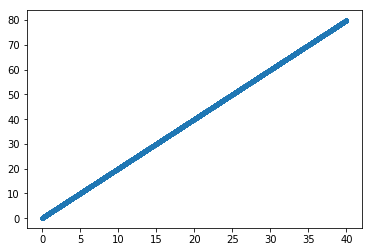

In [5]:
raw_inputs = Input(shape=(1,))
raw_preds = Dense(1, activation='linear', name="preds")(raw_inputs)

rawmodel = Model(inputs=raw_inputs,outputs=raw_preds)
rawmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
rawmodel.fit(x, y, batch_size=128, epochs=40, shuffle=False)
x_raw_pred = np.array([1,2,3,4,5,6,7,8,9,10,15,20])
raw_result = rawmodel.predict(x)
plt.plot(x, raw_result[:,0],'.')
plt.show()

Then we try a model where the sigma is the result of a combination of 3 layers.

In [6]:
inputs = Input(shape=(1,))
sigma = Dense(10, activation='relu', name="sigma", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(inputs)
sigma2 = Dense(5, activation='relu', name="sigma2", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(sigma)
sigma3 = Dense(1, activation='linear', name="sigma3", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(sigma2)
preds = Dense(1, activation='linear', name="preds")(inputs)
aleatoric_output = concatenate([preds, sigma3])
sgd = SGD(lr=0.1)
adam = Adam(lr=0.001)
rms = RMSprop(lr=0.001)
nadam = Nadam(lr=0.001)
model = Model(inputs=inputs,outputs=aleatoric_output)
model.compile(optimizer=nadam, loss=aleatoric_loss, metrics=[aleatoric_rms, aleatoric_uncertainty])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
sigma (Dense)                    (None, 10)            20          input_2[0][0]                    
____________________________________________________________________________________________________
sigma2 (Dense)                   (None, 5)             55          sigma[0][0]                      
____________________________________________________________________________________________________
preds (Dense)                    (None, 1)             2           input_2[0][0]                    
___________________________________________________________________________________________

In [7]:
model.fit(x, np.expand_dims(y, axis=1).repeat(2, axis=1), batch_size=64, epochs=300, shuffle=False)

Epoch 1/300
20000/20000 [==============================] - 0s - loss: 55.9982 - aleatoric_rms: 751.6919 - aleatoric_uncertainty: 1.1048     
Epoch 2/300
20000/20000 [==============================] - 0s - loss: 10.7444 - aleatoric_rms: 686.1473 - aleatoric_uncertainty: 3.9617     
Epoch 3/300
20000/20000 [==============================] - 0s - loss: 8.2723 - aleatoric_rms: 644.2555 - aleatoric_uncertainty: 4.5260     
Epoch 4/300
20000/20000 [==============================] - 0s - loss: 7.4420 - aleatoric_rms: 609.0366 - aleatoric_uncertainty: 4.8663     
Epoch 5/300
20000/20000 [==============================] - 0s - loss: 7.0650 - aleatoric_rms: 576.6910 - aleatoric_uncertainty: 5.0977     
Epoch 6/300
20000/20000 [==============================] - 0s - loss: 6.8633 - aleatoric_rms: 545.3913 - aleatoric_uncertainty: 5.2607     
Epoch 7/300
20000/20000 [==============================] - 0s - loss: 6.7397 - aleatoric_rms: 513.9792 - aleatoric_uncertainty: 5.3738     
Epoch 8/300
20000/

20000/20000 [==============================] - 0s - loss: 2.4745 - aleatoric_rms: 8.2502 - aleatoric_uncertainty: 0.9524     
Epoch 60/300
20000/20000 [==============================] - 0s - loss: 2.4749 - aleatoric_rms: 8.2501 - aleatoric_uncertainty: 0.9528     
Epoch 61/300
20000/20000 [==============================] - 0s - loss: 2.4751 - aleatoric_rms: 8.2499 - aleatoric_uncertainty: 0.9533     
Epoch 62/300
20000/20000 [==============================] - 0s - loss: 2.4754 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.9539     
Epoch 63/300
20000/20000 [==============================] - 0s - loss: 2.4757 - aleatoric_rms: 8.2497 - aleatoric_uncertainty: 0.9544     
Epoch 64/300
20000/20000 [==============================] - 0s - loss: 2.4759 - aleatoric_rms: 8.2496 - aleatoric_uncertainty: 0.9547     
Epoch 65/300
20000/20000 [==============================] - 0s - loss: 2.4762 - aleatoric_rms: 8.2495 - aleatoric_uncertainty: 0.9552     
Epoch 66/300
20000/20000 [==============

20000/20000 [==============================] - 0s - loss: 2.4872 - aleatoric_rms: 8.2497 - aleatoric_uncertainty: 0.9746     
Epoch 118/300
20000/20000 [==============================] - 0s - loss: 2.4873 - aleatoric_rms: 8.2497 - aleatoric_uncertainty: 0.9748     
Epoch 119/300
20000/20000 [==============================] - 0s - loss: 2.4876 - aleatoric_rms: 8.2497 - aleatoric_uncertainty: 0.9753     
Epoch 120/300
20000/20000 [==============================] - 0s - loss: 2.4878 - aleatoric_rms: 8.2497 - aleatoric_uncertainty: 0.9757     
Epoch 121/300
20000/20000 [==============================] - 0s - loss: 2.4880 - aleatoric_rms: 8.2497 - aleatoric_uncertainty: 0.9760     
Epoch 122/300
20000/20000 [==============================] - 0s - loss: 2.4881 - aleatoric_rms: 8.2497 - aleatoric_uncertainty: 0.9760     
Epoch 123/300
20000/20000 [==============================] - 0s - loss: 2.4881 - aleatoric_rms: 8.2497 - aleatoric_uncertainty: 0.9763     
Epoch 124/300
20000/20000 [=======

20000/20000 [==============================] - 0s - loss: 2.4961 - aleatoric_rms: 8.2500 - aleatoric_uncertainty: 0.9907     
Epoch 176/300
20000/20000 [==============================] - 0s - loss: 2.4965 - aleatoric_rms: 8.2500 - aleatoric_uncertainty: 0.9913     
Epoch 177/300
20000/20000 [==============================] - 0s - loss: 2.4964 - aleatoric_rms: 8.2500 - aleatoric_uncertainty: 0.9912     
Epoch 178/300
20000/20000 [==============================] - 1s - loss: 2.4966 - aleatoric_rms: 8.2500 - aleatoric_uncertainty: 0.9916     
Epoch 179/300
20000/20000 [==============================] - 0s - loss: 2.4968 - aleatoric_rms: 8.2500 - aleatoric_uncertainty: 0.9919     
Epoch 180/300
20000/20000 [==============================] - 0s - loss: 2.4971 - aleatoric_rms: 8.2500 - aleatoric_uncertainty: 0.9925     
Epoch 181/300
20000/20000 [==============================] - 0s - loss: 2.4971 - aleatoric_rms: 8.2500 - aleatoric_uncertainty: 0.9924     
Epoch 182/300
20000/20000 [=======

20000/20000 [==============================] - 0s - loss: 2.4534 - aleatoric_rms: 8.2499 - aleatoric_uncertainty: 0.9185     
Epoch 234/300
20000/20000 [==============================] - 0s - loss: 2.4502 - aleatoric_rms: 8.2499 - aleatoric_uncertainty: 0.9129     
Epoch 235/300
20000/20000 [==============================] - 0s - loss: 2.4474 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.9075     
Epoch 236/300
20000/20000 [==============================] - 0s - loss: 2.4451 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.9035     
Epoch 237/300
20000/20000 [==============================] - 0s - loss: 2.4426 - aleatoric_rms: 8.2499 - aleatoric_uncertainty: 0.8991     
Epoch 238/300
20000/20000 [==============================] - 0s - loss: 2.4417 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.8983     
Epoch 239/300
20000/20000 [==============================] - 0s - loss: 2.4402 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.8953     
Epoch 240/300
20000/20000 [=======

20000/20000 [==============================] - 0s - loss: 2.4174 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.8564     
Epoch 292/300
20000/20000 [==============================] - 0s - loss: 2.4172 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.8562     
Epoch 293/300
20000/20000 [==============================] - 0s - loss: 2.4171 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.8561     
Epoch 294/300
20000/20000 [==============================] - 0s - loss: 2.4170 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.8557     
Epoch 295/300
20000/20000 [==============================] - 0s - loss: 2.4166 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.8549     
Epoch 296/300
20000/20000 [==============================] - 0s - loss: 2.4159 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.8539     
Epoch 297/300
20000/20000 [==============================] - 0s - loss: 2.4166 - aleatoric_rms: 8.2498 - aleatoric_uncertainty: 0.8555     
Epoch 298/300
20000/20000 [=======

Here we can see that predictions are still right and the sigmas obtained describe perfectly the variance of the noise introduced in the input data

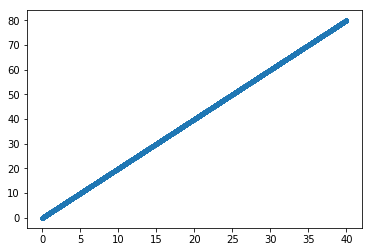

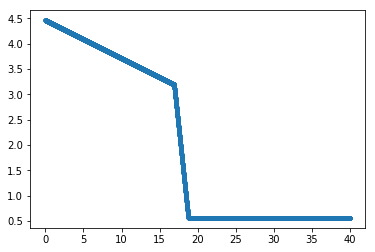

In [8]:
result = model.predict(x)
plt.plot(x, result[:,0],'.')
plt.show()
plt.plot(x, result[:,1],'.')
plt.show()
#result